# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** Catinca Mujdei, Erick Maraz  
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [48]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will find under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [49]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

We first look at the histograms of each dataset.

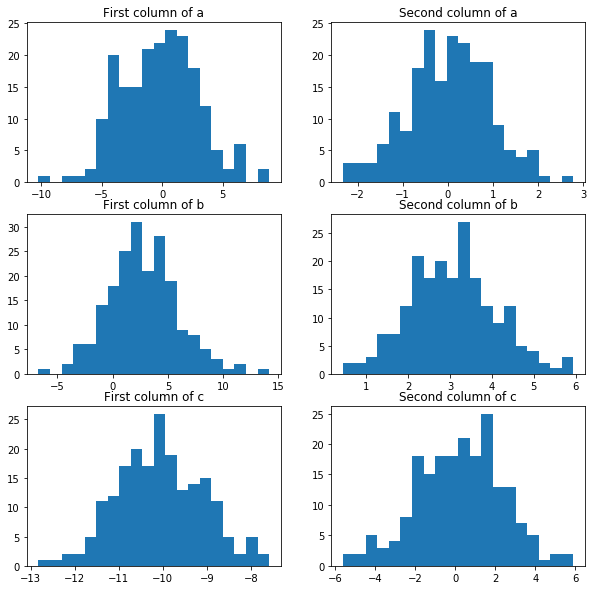

In [50]:
import matplotlib
import matplotlib.pyplot as plt

n_bins = 20

fig, axs = plt.subplots(3, 2, figsize=(10,10))
axs[0,0].hist(a[:,0], bins=n_bins)
axs[0,0].title.set_text('First column of a')
axs[0,1].hist(a[:,1], bins=n_bins)
axs[0,1].title.set_text('Second column of a')
axs[1,0].hist(b[:,0], bins=n_bins)
axs[1,0].title.set_text('First column of b')
axs[1,1].hist(b[:,1], bins=n_bins)
axs[1,1].title.set_text('Second column of b')
axs[2,0].hist(c[:,0], bins=n_bins)
axs[2,0].title.set_text('First column of c')
axs[2,1].hist(c[:,1], bins=n_bins)
axs[2,1].title.set_text('Second column of c')
plt.show()

We can infer from those histograms that, for each dataset, both variables might follow a normal distribution due to the bell-like shape of each plot. Another argument for normality of both columns of each dataset is given by their QQ-plots, which can be computed as shown in the next cell (an example is given for the first column of dataset a). (For this plot, the module ```statsmodels``` is used, although it is not included in the ```requirements.txt``` file.)

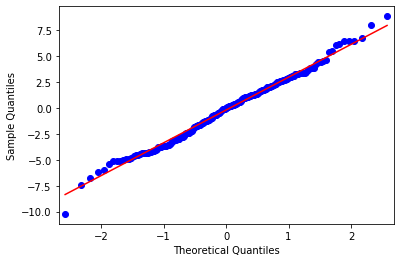

In [51]:
from statsmodels.graphics.gofplots import qqplot

qqplot(a[:,0], line='s')
plt.show()

Since the data points each time nicely cover the straight red line in the QQ-plot (with no more than very little deviations from the line), we can once more conclude that normality is a plausible assumption.

We now take a look at the empirical covariance matrix of each dataset.

In [52]:
import numpy as np

cov_a = np.cov(a, rowvar=False)
cov_b = np.cov(b, rowvar=False)
cov_c = np.cov(c, rowvar=False)
print("Empirical covariance matrix of a:")
print(cov_a)
print("Empirical covariance matrix of b:")
print(cov_b)
print("Empirical covariance matrix of c:")
print(cov_c)

Empirical covariance matrix of a:
[[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
Empirical covariance matrix of b:
[[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]
Empirical covariance matrix of c:
[[0.97013029 0.23458112]
 [0.23458112 4.69756273]]


To simplify our lives (especially when computing the classification lines), it seems that we can conclude two main things from these covariance matrices:
1. The non-diagonal elements of each covariance matrix are relatively small compared to the diagonal elements, so let's assume they are theoretically zero.
2. The covariance matrices of datasets a and b are similar, so let's assume they are theoretically the same.

Furthermore, we were advised at the beginning of this part of the assignment to round the estimated parameters of each distribution to the closest integer value, in which case the above two assumptions are automatically satisfied. The resulting estimated covariance matrices are therefore the following:

In [53]:
cov_a = np.array([[10.0, 0.0], [0.0, 1.0]])
cov_b = np.array([[10.0, 0.0], [0.0, 1.0]])
cov_c = np.array([[1.0, 0.0], [0.0, 5.0]])
print("Estimated covariance matrix of a:")
print(cov_a)
print("Estimated covariance matrix of b:")
print(cov_b)
print("Estimated covariance matrix of c:")
print(cov_c)

Estimated covariance matrix of a:
[[10.  0.]
 [ 0.  1.]]
Estimated covariance matrix of b:
[[10.  0.]
 [ 0.  1.]]
Estimated covariance matrix of c:
[[1. 0.]
 [0. 5.]]


The two assumptions from above can also be justified by looking at the following scatter plot. I.e., every dataset has an ellipse-like shape of which the two main axes are quasi-parallel with the cartesian axes of the plot. And also, the shape of the clouds formed by datasets a and b are very similar.

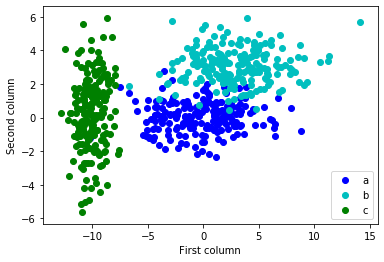

In [54]:
a_dots = plt.scatter(a[:,0], a[:,1], color='b')
b_dots = plt.scatter(b[:,0], b[:,1], color='c')
c_dots = plt.scatter(c[:,0], c[:,1], color='g')

plt.legend((a_dots, b_dots, c_dots), ('a', 'b', 'c'))
plt.xlabel('First column')
plt.ylabel('Second column')
plt.show()

Now, to organize our classification procedure. The Bayesian approach aims at assigning the most probable class to an arbitrary datapoint. To this end, we compute the decision line between each two classes with the discriminant function (for normal distributions).

We start off with the decision line between sets a and b. Since these two sets are assumed to have the same diagonal estimated covariance matrix, we consider the set-up on slide 14 in the slides on classification, which yields a linear decision line; the parameters on this slide are given the same names in the code for building the decision line. Beware that $\log(P(w_i))$ is absent in the computations, since we have no information on the priors of each dataset, and therefore we assume that each prior is the same for each set, i.e., equal to $\frac{1}{3}$.

(Note that the empirical mean for each class is rounded to the nearest integer, as suggested at the start of this part of the assignment. This rounding does not greatly affect the slope of the decision line.)

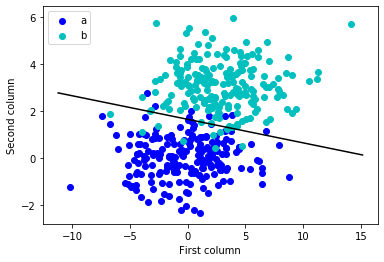

The analytical expression of the separation curve is y=-0.100+1.650*x


In [55]:
mean_a = np.round(np.mean(a, axis=0))
mean_b = np.round(np.mean(b, axis=0))

w_a = np.linalg.inv(cov_a).dot(mean_a)
w_b = np.linalg.inv(cov_b).dot(mean_b)
w_ab = w_a - w_b
w_a0 = - mean_a.dot(w_a) / 2.0
w_b0 = - mean_b.dot(w_b) / 2.0
w_ab0 = w_a0 - w_b0
slope = - w_ab[0] / w_ab[1]
intercept = - w_ab0 / w_ab[1]

max_x = np.max((a[:,0], b[:,0]))
min_x = np.min((a[:,0], b[:,0]))
x = np.linspace(min_x-1, max_x+1, 100)

plt.plot(x, slope * x + intercept, color='k')
a_dots = plt.scatter(a[:,0], a[:,1], color='b')
b_dots = plt.scatter(b[:,0], b[:,1], color='c')
plt.legend((a_dots, b_dots), ('a', 'b'))
plt.xlabel('First column')
plt.ylabel('Second column')
plt.show()

print("The analytical expression of the separation curve is y=%.3f+%.3f*x" % (slope, intercept))

In a nicer format, the equation is given by
$$y=\frac{33}{20}x-\frac{1}{10}.$$

Now for the decision line between sets b and c. In this case, the estimated covariance matrices are both diagonal, yet unequal. We thus apply the formula on slide 12 to compute the decision line. Note that the mean of the considered distributions is once more each time rounded to the nearest integer value, which luckily yields a nicer formula form of the decision line.

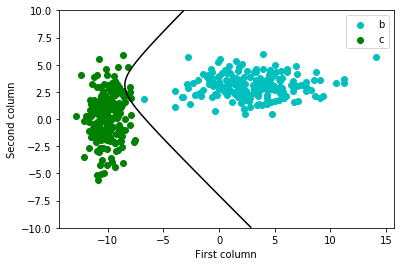

The analytical expression of the separation curve is 
0=-((1/10**2 - 1/1**2) * x**2 + (1/1**2 - 1/5**2) * y**2) / 2
            + (3/10**2 - -10/1**2) * x + (3/1**2 - 0/5**2) * y
            - (((3/10)**2 - (-10/1)**2) + ((3/1)**2 - (0/5)**2)) / 2
            + log((1 * 5) / (10 * 1))


In [56]:
mean_c = np.round(np.mean(c, axis=0))

x = np.linspace(-10, 9, 400)
y = np.linspace(-10, 10, 400)
x, y = np.meshgrid(x, y)

s_bx = cov_b[0,0]
s_by = cov_b[1,1]
s_cx = cov_c[0,0]
s_cy = cov_c[1,1]
m_bx = mean_b[0]
m_by = mean_b[1]
m_cx = mean_c[0]
m_cy = mean_c[1] 

plt.contour(x, y, - ((1/s_bx**2 - 1/s_cx**2) * x**2 + (1/s_by**2 - 1/s_cy**2) * y**2) / 2
            + (m_bx/s_bx**2 - m_cx/s_cx**2) * x + (m_by/s_by**2 - m_cy/s_cy**2) * y
            - (((m_bx/s_bx)**2 - (m_cx/s_cx)**2) + ((m_by/s_by)**2 - (m_cy/s_cy)**2)) / 2
            + np.log((s_cx * s_cy) / (s_bx * s_by)), [0], colors='k')
b_dots = plt.scatter(b[:,0], b[:,1], color='c')
c_dots = plt.scatter(c[:,0], c[:,1], color='g')
plt.legend((b_dots, c_dots), ('b', 'c'))
plt.xlabel('First column')
plt.ylabel('Second column')
plt.show()

print("The analytical expression of the separation curve is ")
print("0=-((1/%i**2 - 1/%i**2) * x**2 + (1/%i**2 - 1/%i**2) * y**2) / 2"
     % (s_bx, s_cx, s_by, s_cy))
print("            + (%i/%i**2 - %i/%i**2) * x + (%i/%i**2 - %i/%i**2) * y"
     % (m_bx, s_bx, m_cx, s_cx, m_by, s_by, m_cy, s_cy))
print("            - (((%i/%i)**2 - (%i/%i)**2) + ((%i/%i)**2 - (%i/%i)**2)) / 2"
     % (m_bx, s_bx, m_cx, s_cx, m_by, s_by, m_cy, s_cy))
print("            + log((%i * %i) / (%i * %i))"
     % (s_cx, s_cy, s_bx, s_by))


In a nicer format, the equation is given by
$$0=\frac{99}{200}x^2-\frac{12}{25}y^2+\frac{1003}{100}x+3y+\frac{9091}{200}-\log(2).$$

And finally, the decision line between sets a and c. The same method applies as for the decision line between datasets b and c.

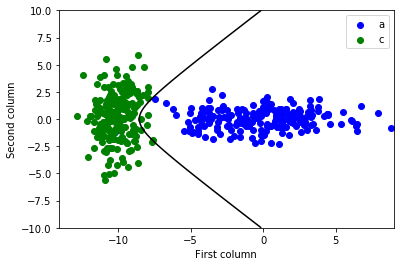

The analytical expression of the separation curve is 
0=-((1/10**2 - 1/1**2) * x**2 + (1/1**2 - 1/5**2) * y**2) / 2
            + (0/10**2 - -10/1**2) * x + (0/1**2 - 0/5**2) * y
            - (((0/10)**2 - (-10/1)**2) + ((0/1)**2 - (0/5)**2)) / 2
            + log((1 * 5) / (10 * 1))


In [57]:
s_ax = cov_a[0,0]
s_ay = cov_a[1,1]
m_ax = mean_a[0]
m_ay = mean_a[1]

plt.contour(x, y, - ((1/s_ax**2 - 1/s_cx**2) * x**2 + (1/s_ay**2 - 1/s_cy**2) * y**2) / 2
            + (m_ax/s_ax**2 - m_cx/s_cx**2) * x + (m_ay/s_ay**2 - m_cy/s_cy**2) * y
            - (((m_ax/s_ax)**2 - (m_cx/s_cx)**2) + ((m_ay/s_ay)**2 - (m_cy/s_cy)**2)) / 2
            + np.log((s_cx * s_cy) / (s_ax * s_ay)), [0], colors='k')
a_dots = plt.scatter(a[:,0], a[:,1], color='b')
c_dots = plt.scatter(c[:,0], c[:,1], color='g')
plt.legend((a_dots, c_dots), ('a', 'c'))
plt.xlabel('First column')
plt.ylabel('Second column')
plt.show()

print("The analytical expression of the separation curve is ")
print("0=-((1/%i**2 - 1/%i**2) * x**2 + (1/%i**2 - 1/%i**2) * y**2) / 2"
     % (s_ax, s_cx, s_ay, s_cy))
print("            + (%i/%i**2 - %i/%i**2) * x + (%i/%i**2 - %i/%i**2) * y"
     % (m_ax, s_ax, m_cx, s_cx, m_ay, s_ay, m_cy, s_cy))
print("            - (((%i/%i)**2 - (%i/%i)**2) + ((%i/%i)**2 - (%i/%i)**2)) / 2"
     % (m_ax, s_ax, m_cx, s_cx, m_ay, s_ay, m_cy, s_cy))
print("            + log((%i * %i) / (%i * %i))"
     % (s_cx, s_cy, s_ax, s_ay))



In a nicer format, the equation is given by
$$0=\frac{99}{200}x^2-\frac{12}{25}y^2+10x+50-\log(2).$$



We now plot the three lines together to get a general image of our findings:

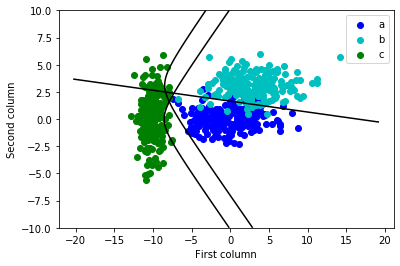

In [58]:
plt.contour(x, y, - ((1/s_ax**2 - 1/s_cx**2) * x**2 + (1/s_ay**2 - 1/s_cy**2) * y**2) / 2
            + (m_ax/s_ax**2 - m_cx/s_cx**2) * x + (m_ay/s_ay**2 - m_cy/s_cy**2) * y
            - (((m_ax/s_ax)**2 - (m_cx/s_cx)**2) + ((m_ay/s_ay)**2 - (m_cy/s_cy)**2)) / 2 
            + np.log((s_cx * s_cy) / (s_ax * s_ay)), [0], colors='k')
plt.contour(x, y, - ((1/s_bx**2 - 1/s_cx**2) * x**2 + (1/s_by**2 - 1/s_cy**2) * y**2) / 2
            + (m_bx/s_bx**2 - m_cx/s_cx**2) * x + (m_by/s_by**2 - m_cy/s_cy**2) * y
            - (((m_bx/s_bx)**2 - (m_cx/s_cx)**2) + ((m_by/s_by)**2 - (m_cy/s_cy)**2)) / 2
            + np.log((s_cx * s_cy) / (s_bx * s_by)), [0], colors='k')
x = np.linspace(min_x-10, max_x+5, 100)
plt.plot(x, slope * x + intercept, color='k')
a_dots = plt.scatter(a[:,0], a[:,1], color='b')
b_dots = plt.scatter(b[:,0], b[:,1], color='c')
c_dots = plt.scatter(c[:,0], c[:,1], color='g')
plt.legend((a_dots, b_dots, c_dots), ('a', 'b', 'c'))
plt.xlabel('First column')
plt.ylabel('Second column')
plt.show()

Points located within the small "triangle" created by the intersections of each pair of lines are not assigned to any class by the Bayesian approach. This region probably exists as an artifact due to the assumptions made on the distributions of the variables as well as on their parameters; this kind of region should theoretically not exist.

Points located on the left of both the parabolas at the same time are assigned to dataset c. 

Remaining points located above the straight line are assigned to dataset b.

Remaining points located underneath the straight line are assigned to dataset c.

### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

The expression of the Mahalanobis distance used to classify a point $P=(x,y)$ is given by (see slide 18)
$$d_m=\sqrt{(P-\mu_i)^T\begin{pmatrix}
  10 & 0\\ 
  0 & 1
\end{pmatrix}^{-1}(P-\mu_i)},$$
where $\mu_i$ stands for the mean of class $i$. The decision line is thus given by 
$$(P-\mu_a)^T\begin{pmatrix}
  10 & 0\\ 
  0 & 1
\end{pmatrix}^{-1}(P-\mu_a)=(P-\mu_b)^T\begin{pmatrix}
  10 & 0\\ 
  0 & 1
\end{pmatrix}^{-1}(P-\mu_b),$$
which reduces to 
$$\frac{1}{10}(x-\mu_{a,x})^2+(y-\mu_{a,y})^2=\frac{1}{10}(x-\mu_{b,x})^2+(y-\mu_{b,y})^2.$$

We now plot the corresponding line in red.

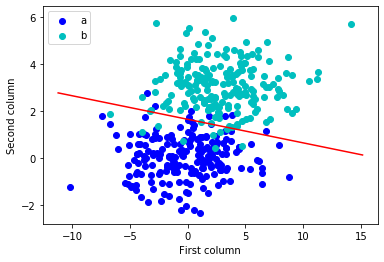

In [59]:
slope_m = - (mean_a[0] - mean_b[0]) / ((mean_a[1] - mean_b[1]) * 10)
intercept_m = (mean_a[0]**2 - mean_b[0]**2) / ((mean_a[1] - mean_b[1]) * 20) + (mean_a[1] + mean_b[1]) / 2

max_x = np.max((a[:,0], b[:,0]))
min_x = np.min((a[:,0], b[:,0]))
x = np.linspace(min_x-1, max_x+1, 100)

plt.plot(x, slope_m * x + intercept_m, color='r')
#plt.plot(x, slope * x + intercept, color='k')  <--- uncomment this line to see that the two lines do indeed overlap
a_dots = plt.scatter(a[:,0], a[:,1], color='b')
b_dots = plt.scatter(b[:,0], b[:,1], color='c')
plt.legend((a_dots, b_dots), ('a', 'b'))
plt.xlabel('First column')
plt.ylabel('Second column')
plt.show()

We can see from the plot that the decision line is the same as when the Bayes classifier is based on Euclidean distance [WAAROM?]. The classifier based on the Mahalanobis distance will thus classify every point the same way.

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP
*Add your implementation and discussion*

In [ ]:
# print(train_images.shape)
# print(train_labels.shape)
# print(test_images.shape)
# print(test_labels.shape)

Preprocessing: Since the MLP is sensitive to the maginitude of its feature vectors. We will normalize them with respect ... TODO

In [ ]:
train_img = train_images / 255.
test_img = test_images / 255.

In [ ]:
flat_train_img = train_img.reshape(train_img.shape[0],-1)
flat_test_img = test_img.reshape(test_img.shape[0],-1)

Since the last layer of MLP and we want values close to one at the end. We well convert our labels to a 'one hot label' representation. In our case the labels vectors will have size 10 (one column for each number) filled with zeros except for the value with index equal to the label (which will be one). 

In [ ]:
def to_one_hot(x, nb_classes):
    output = np.zeros((x.shape[0], nb_classes))
    for i in range(x.shape[0]):
        output[i,x[i]] = 1.
    return output

train_labels = to_one_hot(train_labels, 10)
test_labels = to_one_hot(test_labels, 10)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(100,), random_state=1, max_iter = 500)

mlp.fit(flat_train_img, train_labels)

print("Training set loss: %f" % mlp.loss_)
print("Training set score: %f" % mlp.score(flat_train_img, train_labels))
print("Test set score : %f" % mlp.score(flat_test_img, test_labels ))                

In [ ]:
# different learning rate schedules and momentum parameters

params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'black', 'linestyle': '-'}]

def plot_on_dataset(X_train, y_train, X_test, y_test, name):
    
    print("\nlearning on dataset %s \n" % name)
    
    plt.figure(figsize=(10,5))
    plt.title(name)

#     X = MinMaxScaler().fit_transform(X)
    mlps = []
    max_iter = 500

    for label, param in zip(labels, params):
        print("training: %s" % label)
        
        mlp = MLPClassifier(random_state=0, max_iter=max_iter, **param)
        mlp.fit(X_train, y_train)
        mlps.append(mlp)
        
        print("Training set loss: %f" % mlp.loss_)
        print("Training set score: %f" % mlp.score(X_train, y_train))
        print("Test set score : %f" % mlp.score(X_test,y_test ))        
        print(50 * "-")
        
    for mlp, label, args in zip(mlps, labels, plot_args):
        plt.plot(mlp.loss_curve_, label=label, **args)
    plt.legend(labels, ncol=3, loc="upper right")
    plt.show()

plot_on_dataset(flat_train_img, train_labels, flat_test_img, test_labels, name= 'mnist')